In [6]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

import random as rnd
import time
from pprint import pprint
import altair as alt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import time
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo_utils.algorithm_runner import run_alg, run_alg_parallel
from isri_optimizer.isri_metaheuristic_simple import (ISRIProblem, ISRICrossover, ISRIMutation, ISRISampling, 
ISRIDuplicateElimination, get_dummy_test_data, plan_by_due_date, read_ISRI_Instance, get_fitness)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Aufbereitung von ISRI Instanzen - nur Lokal bei LV ausführbar sucht gute Instanzen
instance_path = 'C:/Users/lvollenkemper/Documents/SUPPORT/Isringhausen/Daten/BatchExport'
path_mjd = 'C:/Users/lvollenkemper/Documents/SUPPORT/Isringhausen/Daten/mtm_info.csv'
files = [
    "NemetrisExportBatch_20230217-143003.csv",
    "NemetrisExportBatch_20230223-134500.csv",
    "NemetrisExportBatch_20230223-103000.csv",
    "NemetrisExportBatch_20230221-203000.csv",
    "NemetrisExportBatch_20230222-114500.csv",
    "NemetrisExportBatch_20230223-080000.csv",
    "NemetrisExportBatch_20230223-121500.csv",
    "NemetrisExportBatch_20230223-171500.csv",
    "NemetrisExportBatch_20230223-180000.csv",
    "NemetrisExportBatch_20230222-104500.csv",
    "NemetrisExportBatch_20230218-124503.csv",
    "NemetrisExportBatch_20230222-043000.csv",
    "NemetrisExportBatch_20230222-084500.csv",
    "NemetrisExportBatch_20230222-191500.csv",
    "NemetrisExportBatch_20230223-053000.csv",
    "NemetrisExportBatch_20230218-081503.csv"
]

instance_data = {
    'file': [],
    'n_jobs': [],
    'worksum': [],
    'reoder_count': []
}

test_instances = []

for file in files:
    print(file)
    t0 = time.time()
    jobs = read_ISRI_Instance(instance_path + "/" + file, path_mjd)
    jobnew = {}
    t1 = time.time()
    t = t1 - t0
    print("Read file in %.2f seconds" %t)
    worksum = np.sum([np.sum(jobs[j]['times']) for j in jobs.keys()])
    reorder_count = np.sum([np.where(jobs[j]['due_date'] == 30*60)[0].shape[0] for j in jobs.keys()])
    instance_data['worksum'].append(worksum)
    instance_data['reoder_count'].append(reorder_count)
    instance_data['file'].append(file)
    instance_data['n_jobs'].append(len(jobs))
    test_instances.append(jobs)
    for i, key in enumerate(jobs):
        jobnew[f"Job {i}"] = jobs[key]

    test_instances.append(jobnew)

with open('isri_test_results/test_instances_isri', "wb") as outfile:
    pickle.dump(test_instances, outfile)
pd.DataFrame(instance_data)


NemetrisExportBatch_20230217-143003.csv


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/lvollenkemper/Documents/SUPPORT/Isringhausen/Daten/BatchExport/NemetrisExportBatch_20230217-143003.csv'

In [4]:
#Lade test instanzen
test_instances = pickle.load(open('isri_test_results/test_instances_isri', "rb"))

In [3]:
JOBS_PER_LINE = 60
N_MACHINES = 10
TIME_RANGE = (2,7)
TRIES_PER_ALG = 5
ALGORITHMS = ["nsga2", "moead", "rvea", "ctaea", "unsga3"]
param = {
    'jobs': None,
    'problem_getter': ISRIProblem,
    'crossover': ISRICrossover(0.95),
    'mutation': ISRIMutation(0.1),
    'sampling': ISRISampling(),
    'eliminate_duplicates': ISRIDuplicateElimination(),
    'n_jobs': None,
    'n_machines': N_MACHINES,
    'time_range': TIME_RANGE,
    'jobs_per_line': JOBS_PER_LINE,
    'alg_name': 'unsga3',
    'obj_weights': [0.8, 0.2], # 1: min geglättete belastung, max minimalen due date puffer
    'conveyor_speed': 145,
    'ma_window_size': 2,
    'n_evals': 10000, # number of fitness calculations,
    'seed': 1,
    'parallelization_method': 'multi_threading', # multi_threading | multi_processing | dask
    'n_parallelizations': 8, # number threads or processes,
    'print_results': False,
    'print_iterations': False, # number threads or processes,
    'adaptive_rate_mode': 'none', # none | icdm | imdc
    'criterion': 'minvar',
    'plot_solution': False# 'minmax' | 'minavg' | 'minvar'
}

In [ ]:
results = {
    "Algorithm": [],
    "TryNr": [],
    "InstanceNr": [],
    "FitnessWorkload": [],
    "FitnessDeadline": [],
    "RandomSeed": [],
    "BestChromosome": []
}

for alg in ALGORITHMS:
    print(f"Starting Algorithm {alg}")
    for nr, instance in enumerate(test_instances[:10]):
        param['jobs'] = instance
        param['n_jobs'] = len(instance)
        due_date_sorting = plan_by_due_date(instance, jpl=param['jobs_per_line'])
        problem = ISRIProblem(param, runner=None)
        problem.plot_solution(due_date_sorting, f'isri_test_results/heatmap_due_date_sorted_inst_{nr}.svg')
        problem.plot_deadline_gap(due_date_sorting, f'isri_test_results/deadline_due_date_sorted_inst_{nr}.svg')
        print(f"...Instance {nr}")
        for trynr in range(TRIES_PER_ALG):
            rdm_seed = np.random.randint(1, 500000)
            param["alg_name"] = alg
            param["seed"] = rdm_seed
            res, best_chromosome, best_fitness = run_alg_parallel(run_alg, param)
            problem.plot_solution(best_chromosome, f'isri_test_results/heatmap_{alg}_inst_{nr}_try_{trynr}.svg')
            problem.plot_deadline_gap(best_chromosome, f'isri_test_results/deadline_{alg}_inst_{nr}_try_{trynr}.svg')
            results["Algorithm"].append(alg)
            results["TryNr"].append(trynr)
            results["InstanceNr"].append(nr)
            results["FitnessWorkload"].append(best_fitness[0])
            results["FitnessDeadline"].append(best_fitness[1])
            results["RandomSeed"].append(rdm_seed)
            results["BestChromosome"].append(best_chromosome)
            plt.close('all')

results = pd.DataFrame(results)
results.to_csv("isri_test_results/Ergebnisse_ISRI_Experimente_part2.csv", index=False, sep=";")
results

In [8]:
results = pd.DataFrame(results)
results.to_csv("isri_test_results/Ergebnisse_ISRI_Experimente.csv", index=False, sep=";")
results

NameError: name 'results' is not defined

In [6]:
results = pd.read_csv("isri_test_results/Ergebnisse_ISRI_Experimente.csv", header=0, sep=";")

In [7]:
results_2 = pd.read_csv("isri_test_results/Ergebnisse_ISRI_Experimente_part2.csv", header=0, sep=";")

In [22]:
results = pd.concat((results, results_2))


,Algorithm,TryNr,InstanceNr,FitnessWorkload,FitnessDeadline,RandomSeed,BestChromosome
0,nsga2,0,0,1162.464547,58.908868,226983,[4285022 4284943 4285028 ... 6942437 6942438 6...
1,nsga2,1,0,1170.549900,61.971970,344813,[6940947 4284943 6940730 ... 4286556 4286432 4...
2,nsga2,2,0,1161.106742,61.030751,25670,[4284943 4284881 4285028 ... 4286556 4286432 4...
3,nsga2,3,0,1167.485415,61.924044,202351,[4285022 6940625 4285038 ... 6942437 6942438 6...
4,nsga2,4,0,1175.659658,59.023511,343874,[6941040 4284943 4285028 ... 6942437 6942438 6...
...,...,...,...,...,...,...,...
245,unsga3,0,9,1412.960120,75.652982,239603,['Job 16' 'Job 2' 'Job 1266' ... 'Job 1243' 'J...
246,unsga3,1,9,1357.605629,79.440598,9342,['Job 0' 'Job 2' 'Job 10' ... 'Job 1243' 'Job ...
247,unsga3,2,9,1406.164356,77.008384,20751,['Job 1302' 'Job 2' 'Job 4' ... 'Job 1243' 'Jo...
248,unsga3,3,9,1355.683143,78.263078,389230,['Job 1300' 'Job 4' 'Job 1288' ... 'Job 1243' ...


In [61]:
per_alg = results[results.InstanceNr == 1].groupby("Algorithm")
boxplot_data = []
ticklabels = []
for alg, grp in per_alg:
    boxplot_data.append(grp.FitnessWorkload.to_list())
    ticklabels.append(alg)
min_values = [np.median(vals) for vals in boxplot_data]
sort = np.argsort(min_values)
boxplot_data_sorted = [boxplot_data[i] for i in sort]

In [62]:
param["alg_name"] = 'ctaea'
param["seed"] = 1234
param['jobs'] = test_instances[2]
param['n_jobs'] = len(test_instances[0])
param['ma_window_size'] = 4
full_deadline = plan_by_due_date(param['jobs'], param['jobs_per_line'])

In [63]:
get_fitness(full_deadline, param['jobs'], param['jobs_per_line'], param['conveyor_speed'], param['n_machines'],
           param['ma_window_size'], return_value='minvar')

(459.54630168877503, 22.809897092568406)

In [10]:
plt.figure(figsize=[4, 3])
plt.boxplot(boxplot_data_sorted, labels=ticklabels)
plt.ylabel("Ergebnis Belastungsvarianz", fontsize=10)
plt.title("Vergleich verschiedener Algorithmen", fontsize=10)
plt.tight_layout()
plt.savefig("isri_test_results/Boxplot_Instanz_0.svg")

NameError: name 'boxplot_data_sorted' is not defined

<Figure size 400x300 with 0 Axes>

In [36]:
INSTANCE = 8

data = results[results.InstanceNr == INSTANCE][['Algorithm', 'FitnessWorkload']]
chart = alt.Chart(data).mark_boxplot(extent=0.5, size=40).encode(
    x='Algorithm:O',
    y=alt.Y('FitnessWorkload:Q', scale=alt.Scale(zero=False)),
    color = alt.Color('Algorithm:O', legend=None, scale=alt.Scale(scheme='category10'))
).properties(
    width=300,
    height=200
).configure_axis(
    labelFont="Arial",
    labelFontSize=10,
    titleFontSize=12,
    title=""
)
chart

alt.Chart(...)

In [ ]:
chart.save("method_comparison_instance_6.svg")

In [ ]:
pivot = pd.pivot_table(results, values="FitnessWorkload", index=['InstanceNr'], columns=['Algorithm'], aggfunc={'FitnessWorkload': [np.mean, lambda x: np.percentile(x, q=90) - np.percentile(x, q=10)]})
pivot

In [11]:
def plot_solution(minvar, minmax, minavg, deadline, jpl, jobs, conveyor_speed, n_machines, ma_window_size, savepath=None):
    worker_load_minvar, min_due_date_buffer = get_fitness(minvar, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')
    worker_load_minmax, min_due_date_buffer = get_fitness(minmax, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')
    worker_load_minavg, min_due_date_buffer = get_fitness(minavg, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')
    worker_load_deadline, min_due_date_buffer = get_fitness(deadline, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')

    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    img_data = [worker_load_minvar, worker_load_minmax, worker_load_minavg, worker_load_deadline]
    img_titles = ['Min Varianz', 'Min Maximum', "Min Durchschnitt", 'Verspätung']
    fig, axs = plt.subplots(1, 4, figsize=(7, 3))
    for idx, ax in enumerate(axs):
        im = ax.imshow(img_data[idx], cmap='RdYlGn_r', aspect='auto')
        im.set_clim(vmin=-conveyor_speed, vmax=-0)
        if idx == 0:
            ax.set_ylabel("Werker", fontname='Arial', fontsize=10)
        ax.set_xlabel("Produkt Nr", fontname='Arial', fontsize=10)
        ax.set_yticks(np.arange(0, img_data[idx].shape[0], 3))
        ax.set_title(img_titles[idx], fontname='Arial', fontsize=10)
        divider = make_axes_locatable(ax)
        cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
        fig.add_axes(cax)
        cb = fig.colorbar(im, cax = cax, orientation = 'horizontal', ticks=[np.min(img_data[idx])+1,
                                                                            np.median(img_data[idx]),
                                                                            np.min([0, np.max(img_data[idx])])])
        cb.set_ticklabels(["Min", "Median", "Max"], fontname='Arial', fontsize=10, rotation=90)
    fig.tight_layout()
    if savepath is None:
        plt.show()
    else:
        plt.savefig(savepath, format='svg')

In [5]:
def plot_histogram(minvar, minmax, minavg, deadline, jpl, jobs, conveyor_speed, n_machines, ma_window_size, savepath=None):
    worker_load_minvar, buffer_minvar = get_fitness(minvar, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')
    worker_load_minmax, buffer_minmax = get_fitness(minmax, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')
    worker_load_minavg, buffer_minavg = get_fitness(minavg, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')
    worker_load_deadline, buffer_deadline = get_fitness(deadline, jobs, jpl=jpl, conv_speed=conveyor_speed,
     n_machines=n_machines, ma_window_size=ma_window_size, return_value='full_workload')
    
    fig = plt.figure(figsize=[7, 3])
    buffers = [buffer_minvar, buffer_minmax, buffer_minavg, buffer_deadline]
    titles = ['Minvar', 'MinMax', 'MinAvg', 'Deadline']
    colors = ['#7fc97f', '#386cb0', '#Bf5b17', '#666666']
    for idx, buffer in enumerate(buffers):
        plt.hist(np.array(buffer)/3600, label=titles[idx], histtype='step', ec=colors[idx])
        
    plt.xlabel("Verspätung in Stunden", fontname='Arial', fontsize=10)
    plt.ylabel("Anzahl Produkte", fontname='Arial', fontsize=10)
    plt.title("Verteilung der Verspätung", fontname='Arial', fontsize=10)
    plt.xticks(fontsize=10, fontname='Arial')
    plt.yticks(fontsize=10, fontname='Arial')
    legend = plt.legend(fontsize=8)
    plt.tight_layout()
    if savepath is None:
        plt.show()
    else:
        plt.savefig(savepath, format='svg')

In [6]:
instance_path = 'C:/Users/lvollenkemper/Documents/SUPPORT/Isringhausen/Daten/BatchExport'
path_mjd = 'C:/Users/lvollenkemper/Documents/SUPPORT/Isringhausen/Daten/mtm_info.csv'
# instance = read_ISRI_Instance(instance_path + "/" + 'NemetrisExportBatch_20230218-081503.csv', path_mjd)
instance = test_instances[9]
param["alg_name"] = 'ctaea'
param["seed"] = 789
param['jobs'] = instance
param['n_jobs'] = len(instance)
param['ma_window_size'] = 1
param['conveyor_speed'] = 200

full_deadline = plan_by_due_date(param['jobs'], param['jobs_per_line'])
param['criterion'] = 'minvar'
res_minvar, minvar, best_fitness_minvar = run_alg_parallel(run_alg, param)
param['criterion'] = 'minmax'
res_minmax, minmax, best_fitness_minmax = run_alg_parallel(run_alg, param)
param['criterion'] = 'minavg'
res_minavg, minavg, best_fitness_minavg = run_alg_parallel(run_alg, param)

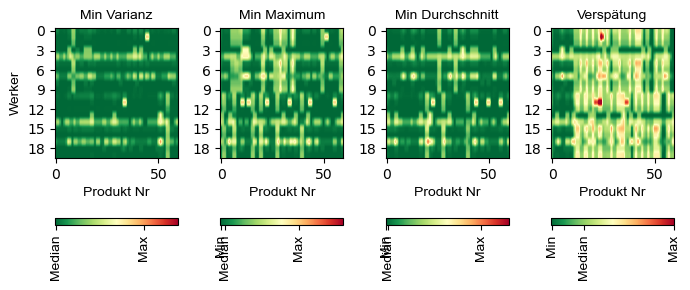

In [12]:
plot_solution(minvar, minmax, minavg, full_deadline, param['jobs_per_line'], param['jobs'], param['conveyor_speed'],
              param['n_machines'], param['ma_window_size'], 'isri_test_results/row_plot.svg

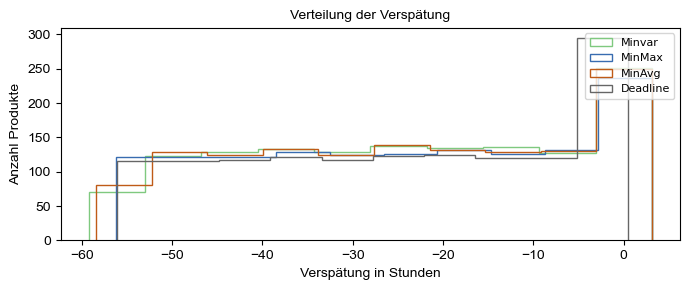

In [8]:
plot_histogram(minvar, minmax, minavg, full_deadline, param['jobs_per_line'], param['jobs'], param['conveyor_speed'],
              param['n_machines'], param['ma_window_size'], 'isri_test_results/hist_plot.svg')

In [27]:
# Gute Instanzen:
0 - mittel
1 - schlecht

NameError: name 'mittel' is not defined